# Week 5: Unsloth Fine-tuning for Sentiment Classification

## Overview

This notebook fine-tunes a small LLaMA-family model using **Unsloth** for ternary sentiment classification (Negative/Neutral/Positive) on Amazon product reviews.

### Key Features:
- ✅ **Unsloth-based fine-tuning** with LoRA + 4-bit quantization
- ✅ **Chronological split** (same as Week 4) to prevent data leakage
- ✅ **Instruction-style SFT format** for LLM training
- ✅ **Colab-ready** with GPU checks and flexible data loading
- ✅ **Reproducible** with random seeds and split summaries

### Dataset:
- **Source**: Amazon_Data.csv
- **Target**: Sentiment labels derived from ratings:
  - Rating ≤ 2 → Negative (label 0)
  - Rating = 3 → Neutral (label 1)
  - Rating ≥ 4 → Positive (label 2)

### Split Strategy:
- **70% Train** (oldest data)
- **15% Validation** (middle)
- **15% Test** (most recent data)

**⚠️ CRITICAL**: No shuffling before split - maintains strict chronological order to prevent temporal leakage.


## 1. Install Dependencies

Install required packages for Unsloth fine-tuning. This cell should be run first in Colab.


In [3]:
# Install Unsloth and dependencies
%pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git" --quiet
%pip install --no-deps "xformers<0.0.27" "trl<0.9.0" "peft<0.10.0" "accelerate<0.30.0" "bitsandbytes<0.43.0" --quiet
%pip install "datasets>=2.18.0" "transformers>=4.40.0" "evaluate>=0.4.1" "scikit-learn>=1.3.0" --quiet

print("✓ Dependencies installed successfully")


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user


## 2. Mount Google Drive

Mount Google Drive to access the dataset file.


In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("✓ Google Drive mounted successfully")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted successfully


## 3. GPU Check

Verify GPU availability (required for Unsloth fine-tuning).


In [5]:
import torch

# Check GPU availability
if torch.cuda.is_available():
    print(f"✓ GPU available: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️  WARNING: No GPU detected. Unsloth fine-tuning requires a GPU.")
    print("   Please enable GPU in Colab: Runtime → Change runtime type → GPU (T4 or A100)")
    raise RuntimeError("GPU required for Unsloth fine-tuning")


✓ GPU available: NVIDIA A100-SXM4-40GB
  GPU Memory: 42.47 GB


## 4. Imports and Configuration


In [6]:
import pandas as pd
import numpy as np
import os
import random
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Define utility functions inline (Colab-compatible)
def load_dataset():
    """
    Load Amazon_Data.csv from Google Drive or Colab upload.
    Colab-only: checks /content/drive/MyDrive/Amazon_Data.csv and /content/Amazon_Data.csv
    """
    possible_paths = [
        "/content/drive/MyDrive/Amazon_Data.csv",
        "/content/Amazon_Data.csv",
    ]
    for path in possible_paths:
        if os.path.exists(path):
            df = pd.read_csv(path)
            print(f"✓ Found file at: {path}")
            print(f"Dataset loaded: {len(df):,} rows, {len(df.columns)} columns")
            return df
    raise FileNotFoundError(
        "Could not find Amazon_Data.csv.\n"
        "Please upload Amazon_Data.csv to one of these locations:\n"
        "  - /content/drive/MyDrive/Amazon_Data.csv (Google Drive)\n"
        "  - /content/Amazon_Data.csv (Colab upload)\n"
        "Then re-run this cell."
    )

def clean_data(df):
    """Clean the dataset: remove nulls, convert timestamp, remove empty text."""
    df = df[['text', 'rating', 'timestamp']].copy()
    print(f"Before cleaning: {len(df):,} rows")
    df = df.dropna()
    print(f"After removing nulls: {len(df):,} rows")
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df = df.dropna(subset=['timestamp'])
    print(f"After timestamp conversion: {len(df):,} rows")
    df = df[df['text'].astype(str).str.len() > 0].copy()
    print(f"After removing empty text: {len(df):,} rows")
    df = df.sort_values('timestamp').reset_index(drop=True)
    print(f"\nDate range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    return df

def create_sentiment_labels(df):
    """Create sentiment labels from ratings (0=Negative, 1=Neutral, 2=Positive)."""
    df = df.copy()
    df['sentiment_label'] = df['rating'].apply(lambda r: 0 if r <= 2 else (1 if r == 3 else 2))
    label_counts = df['sentiment_label'].value_counts().sort_index()
    print("\n" + "=" * 60)
    print("TARGET DISTRIBUTION (Rating-Based Labels)")
    print("=" * 60)
    print(f"  Negative (1-2 stars): {label_counts.get(0, 0):,} ({label_counts.get(0, 0)/len(df)*100:.1f}%)")
    print(f"  Neutral (3 stars):     {label_counts.get(1, 0):,} ({label_counts.get(1, 0)/len(df)*100:.1f}%)")
    print(f"  Positive (4-5 stars):  {label_counts.get(2, 0):,} ({label_counts.get(2, 0)/len(df)*100:.1f}%)")
    print("=" * 60)
    return df

def chronological_split(df, train_ratio=0.70, val_ratio=0.15):
    """Split dataframe chronologically by timestamp."""
    n_total = len(df)
    n_train = int(train_ratio * n_total)
    n_val = int(val_ratio * n_total)
    df_train = df.iloc[:n_train].copy()
    df_val = df.iloc[n_train:n_train + n_val].copy()
    df_test = df.iloc[n_train + n_val:].copy()
    y_train = df_train['sentiment_label'].values
    y_val = df_val['sentiment_label'].values
    y_test = df_test['sentiment_label'].values
    print("=" * 60)
    print("CHRONOLOGICAL SPLIT COMPLETE")
    print("=" * 60)
    print(f"Train set: {len(df_train):,} samples ({len(df_train)/n_total*100:.1f}%)")
    print(f"  Date range: {df_train['timestamp'].min()} to {df_train['timestamp'].max()}")
    print(f"\nValidation set: {len(df_val):,} samples ({len(df_val)/n_total*100:.1f}%)")
    print(f"  Date range: {df_val['timestamp'].min()} to {df_val['timestamp'].max()}")
    print(f"\nTest set: {len(df_test):,} samples ({len(df_test)/n_total*100:.1f}%)")
    print(f"  Date range: {df_test['timestamp'].min()} to {df_test['timestamp'].max()}")
    assert df_train['timestamp'].max() <= df_val['timestamp'].min(), "Train/Val overlap!"
    assert df_val['timestamp'].max() <= df_test['timestamp'].min(), "Val/Test overlap!"
    print("\n✓ Sanity checks passed: no temporal overlap")
    print("=" * 60)
    return df_train, df_val, df_test, y_train, y_val, y_test

def label_to_string(label):
    """Convert numeric label to string."""
    return {0: "Negative", 1: "Neutral", 2: "Positive"}[label]

def string_to_label(label_str):
    """Convert string label to numeric."""
    label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
    label_str_lower = label_str.strip().lower()
    for key, value in label_map.items():
        if key.lower() in label_str_lower or label_str_lower in key.lower():
            return value
    return 1  # Default to Neutral if unclear

# Unsloth imports
from unsloth import FastLanguageModel
import torch
from trl import SFTTrainer
from transformers import TrainingArguments
from datasets import Dataset

# Evaluation imports
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
RANDOM_STATE = 319302
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

print("✓ Imports complete")


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
✓ Imports complete


## 5. Load and Prepare Data

Load the dataset and apply the same chronological split logic as Week 4.


In [8]:
# --- Start of redefinition of load_dataset to handle ParserError ---
# This redefinition overrides the one in cell FaBkRFuWgDHB for this cell's execution.
def load_dataset():
    """
    Load Amazon_Data.csv from Google Drive or Colab upload.
    Colab-only: checks /content/drive/MyDrive/Amazon_Data.csv and /content/Amazon_Data.csv
    Modified to handle ParserError.
    """
    possible_paths = [
        "/content/drive/MyDrive/Amazon_Data.csv",
        "/content/Amazon_Data.csv",
    ]
    for path in possible_paths:
        if os.path.exists(path):
            try:
                # Added 'engine='python'' for better handling of malformed CSVs
                # and 'on_bad_lines='warn'' to log issues without skipping by default
                df = pd.read_csv(path, engine='python', on_bad_lines='warn')
                print(f"✓ Found file at: {path}")
                print(f"Dataset loaded: {len(df):,} rows, {len(df.columns)} columns")
                return df
            except pd.errors.ParserError as e:
                print(f"⚠️  ParserError encountered while reading {path}: {e}")
                print("   Attempting to read with 'on_bad_lines=skip' to bypass problematic rows.")
                try:
                    df = pd.read_csv(path, engine='python', on_bad_lines='skip')
                    print(f"✓ Found file at: {path}")
                    print(f"Dataset loaded (some rows might have been skipped due to errors): {len(df):,} rows, {len(df.columns)} columns")
                    return df
                except Exception as inner_e:
                    raise FileNotFoundError(
                        f"Failed to load dataset even with 'on_bad_lines=skip'. Original error: {e}. Second attempt error: {inner_e}\n"
                        "Please check the CSV file for structural issues."
                    ) from inner_e
    raise FileNotFoundError(
        "Could not find Amazon_Data.csv.\n"
        "Please upload Amazon_Data.csv to one of these locations:\n"
        "  - /content/drive/MyDrive/Amazon_Data.csv (Google Drive)\n"
        "  - /content/Amazon_Data.csv (Colab upload)\n"
        "Then re-run this cell."
    )
# --- End of redefinition of load_dataset ---


# Load dataset
print("Loading dataset...")
df = load_dataset()

# Clean data
print("\nCleaning data...")
df = clean_data(df)

# Create sentiment labels from ratings
print("\nCreating sentiment labels...")
df = create_sentiment_labels(df)

# Chronological split (70/15/15)
print("\nPerforming chronological split...")
df_train, df_val, df_test, y_train, y_val, y_test = chronological_split(df)

print(f"\n✓ Data preparation complete")
print(f"  Train: {len(df_train):,} samples")
print(f"  Val:   {len(df_val):,} samples")
print(f"  Test:  {len(df_test):,} samples")

Loading dataset...
✓ Found file at: /content/Amazon_Data.csv
Dataset loaded: 626,716 rows, 10 columns

Cleaning data...
Before cleaning: 626,716 rows
After removing nulls: 626,547 rows
After timestamp conversion: 626,547 rows
After removing empty text: 626,547 rows

Date range: 2000-11-01 04:24:18 to 2023-07-04 18:23:28.627000

Creating sentiment labels...

TARGET DISTRIBUTION (Rating-Based Labels)
  Negative (1-2 stars): 125,750 (20.1%)
  Neutral (3 stars):     51,304 (8.2%)
  Positive (4-5 stars):  449,493 (71.7%)

Performing chronological split...
CHRONOLOGICAL SPLIT COMPLETE
Train set: 438,582 samples (70.0%)
  Date range: 2000-11-01 04:24:18 to 2020-11-24 23:32:26.171000

Validation set: 93,982 samples (15.0%)
  Date range: 2020-11-24 23:33:01.179000 to 2021-08-23 19:57:37.007000

Test set: 93,983 samples (15.0%)
  Date range: 2021-08-23 20:01:15.714000 to 2023-07-04 18:23:28.627000

✓ Sanity checks passed: no temporal overlap

✓ Data preparation complete
  Train: 438,582 samples


## 6. Prepare Dataset for Unsloth (Instruction Format)

Convert classification task to instruction-following format for LLM fine-tuning.


In [10]:
def create_instruction_prompt(text):
    """
    Create instruction prompt for sentiment classification.

    Args:
        text: Review text

    Returns:
        str: Formatted instruction prompt
    """
    prompt = f"""Classify the sentiment of this review as one of: Negative, Neutral, Positive.

Review: {text}

Answer:"""
    return prompt


def prepare_dataset_for_unsloth(df_split, y_split):
    """
    Prepare dataset in Hugging Face format with instruction prompts.

    Args:
        df_split: Dataframe with 'text' column
        y_split: Array of numeric labels (0, 1, 2)

    Returns:
        Dataset: Hugging Face dataset with 'text' and 'label' fields
    """
    texts = []
    labels = []

    # Use zip to iterate over dataframe rows and label array simultaneously
    # This avoids IndexError caused by mismatched indices (df indices vs 0-based array)
    for (_, row), label_val in zip(df_split.iterrows(), y_split):
        # Create instruction prompt
        instruction = create_instruction_prompt(row['text'])
        texts.append(instruction)

        # Convert numeric label to string
        label_str = label_to_string(label_val)
        labels.append(label_str)

    # Create Hugging Face dataset
    dataset_dict = {
        'text': texts,
        'label': labels
    }

    dataset = Dataset.from_dict(dataset_dict)
    return dataset


# Prepare datasets
print("Preparing training dataset...")
train_dataset = prepare_dataset_for_unsloth(df_train, y_train)

print("Preparing validation dataset...")
val_dataset = prepare_dataset_for_unsloth(df_val, y_val)

print("Preparing test dataset...")
test_dataset = prepare_dataset_for_unsloth(df_test, y_test)

print(f"\n✓ Datasets prepared:")
print(f"  Train: {len(train_dataset):,} examples")
print(f"  Val:   {len(val_dataset):,} examples")
print(f"  Test:  {len(test_dataset):,} examples")

Preparing training dataset...
Preparing validation dataset...
Preparing test dataset...

✓ Datasets prepared:
  Train: 438,582 examples
  Val:   93,982 examples
  Test:  93,983 examples


## 7. Load Model with Unsloth

Load a small LLaMA-family model with 4-bit quantization and LoRA adapters.


In [11]:
# Model configuration
# Using Llama-3.1-8B-Instruct for good balance of performance and speed
# Alternatives: "unsloth/llama-3.1-8b-bnb-4bit" or "unsloth/Qwen2.5-7B-Instruct-bnb-4bit"
model_name = "unsloth/llama-3.1-8b-bnb-4bit"

print(f"Loading model: {model_name}")
print("This may take a few minutes on first run...")

# Load model with 4-bit quantization
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    max_seq_length=512,  # Adjust based on your review length
    dtype=None,  # Auto-detect
    load_in_4bit=True,  # 4-bit quantization
)

# Add LoRA adapters for efficient fine-tuning
model = FastLanguageModel.get_peft_model(
    model,
    r=16,  # LoRA rank (higher = more capacity, but slower)
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,  # LoRA alpha scaling
    lora_dropout=0.1,  # Dropout for LoRA
    bias="none",  # No bias
    use_gradient_checkpointing=True,  # Save memory
    random_state=RANDOM_STATE,
)

print("✓ Model loaded successfully")
print(f"  Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Loading model: unsloth/llama-3.1-8b-bnb-4bit
This may take a few minutes on first run...
==((====))==  Unsloth 2026.1.2: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.1.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2026.1.2 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


✓ Model loaded successfully
  Model parameters: 4,582,543,360
  Trainable parameters: 41,943,040


## 8. Configure Tokenizer and Format Dataset

Set up tokenizer for instruction-following format and prepare datasets for training.


In [13]:
# Configure tokenizer
# tokenizer = FastLanguageModel.get_peft_tokenizer(model) # REMOVED: Method does not exist and tokenizer is already loaded

# Ensure pad_token is set (if not already)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

tokenizer.padding_side = "right"

# Format dataset for training (instruction + completion)
def format_dataset(examples):
    """
    Format dataset for instruction-following training.
    Each example has 'text' (instruction) and 'label' (completion).
    """
    inputs = examples['text']
    outputs = examples['label']

    # Combine instruction and completion
    texts = [f"{inp}{out}" for inp, out in zip(inputs, outputs)]

    # Tokenize
    tokenized = tokenizer(
        texts,
        truncation=True,
        max_length=512,
        padding=False,
    )

    # For causal LM, labels are the same as input_ids
    tokenized['labels'] = tokenized['input_ids'].copy()

    return tokenized


# Apply formatting
print("Formatting training dataset...")
train_dataset_formatted = train_dataset.map(
    format_dataset,
    batched=True,
    remove_columns=train_dataset.column_names,
)

print("Formatting validation dataset...")
val_dataset_formatted = val_dataset.map(
    format_dataset,
    batched=True,
    remove_columns=val_dataset.column_names,
)

print("✓ Datasets formatted for training")

Formatting training dataset...


Map:   0%|          | 0/438582 [00:00<?, ? examples/s]

Formatting validation dataset...


Map:   0%|          | 0/93982 [00:00<?, ? examples/s]

✓ Datasets formatted for training


## 9. Training Configuration

Set up training arguments for fine-tuning.


In [14]:
# Training arguments
training_args = TrainingArguments(
    per_device_train_batch_size=2,  # Small batch size for memory efficiency
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,  # Effective batch size = 2 * 4 = 8
    warmup_steps=50,
    num_train_epochs=1,  # Start with 1 epoch (can increase to 2-3 if needed)
    learning_rate=2e-4,  # Learning rate for LoRA
    fp16=not torch.cuda.is_bf16_supported(),  # Use fp16 if bf16 not supported
    bf16=torch.cuda.is_bf16_supported(),  # Use bf16 if supported (A100)
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=500,  # Evaluate every 500 steps
    save_strategy="steps",
    save_steps=500,
    output_dir="./outputs",
    optim="adamw_8bit",  # 8-bit optimizer to save memory
    load_best_model_at_end=True,
    report_to="none",  # Disable wandb/tensorboard
    seed=RANDOM_STATE,
)

print("✓ Training arguments configured")
print(f"  Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"  Total steps: ~{len(train_dataset_formatted) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps) * training_args.num_train_epochs}")


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

## 10. Fine-tune Model

Train the model using SFTTrainer from Unsloth.


In [ ]:
# Create trainer
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset_formatted,
    eval_dataset=val_dataset_formatted,
    args=training_args,
    dataset_text_field="text",  # Not used since we pre-formatted, but required
    max_seq_length=512,
    packing=False,  # Don't pack sequences
)

print("✓ Trainer created")
print("\nStarting training...")
print("This may take 30-60 minutes depending on GPU and dataset size.")

# Train
trainer_stats = trainer.train()

print("\n✓ Training complete!")
print(f"  Training loss: {trainer_stats.training_loss:.4f}")


## 11. Save Model

Save the fine-tuned model for later use.


In [ ]:
# Save model
model.save_pretrained("unsloth_sentiment_model")
tokenizer.save_pretrained("unsloth_sentiment_model")

print("✓ Model saved to 'unsloth_sentiment_model/'")


## 12. Inference Function

Create a function to run inference on new examples.


In [16]:
# Enable inference mode
FastLanguageModel.for_inference(model)  # Enable native 2x faster inference

def predict_sentiment(text, model=model, tokenizer=tokenizer):
    """
    Predict sentiment for a single review text.

    Args:
        text: Review text
        model: Fine-tuned model
        tokenizer: Tokenizer

    Returns:
        str: Predicted label ("Negative", "Neutral", or "Positive")
    """
    # Create instruction prompt
    prompt = create_instruction_prompt(text)

    # Tokenize
    inputs = tokenizer(
        [prompt],
        return_tensors="pt",
        truncation=True,
        max_length=512,
    ).to("cuda")

    # Generate
    outputs = model.generate(
        **inputs,
        max_new_tokens=5,  # Short generation (just the label)
        temperature=0.0,  # Deterministic
        do_sample=False,  # Greedy decoding
        pad_token_id=tokenizer.eos_token_id,
    )

    # Decode
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract answer (everything after "Answer:")
    if "Answer:" in generated_text:
        answer = generated_text.split("Answer:")[-1].strip()
    else:
        answer = generated_text.strip()

    # Parse label (take first word, handle case variations)
    answer_words = answer.split()
    if len(answer_words) > 0:
        predicted_label = answer_words[0].strip()
    else:
        predicted_label = answer.strip()

    # Normalize to one of our labels
    predicted_label = string_to_label(predicted_label)
    return label_to_string(predicted_label)


# Test on a few examples
print("Testing inference on sample reviews:")
print("=" * 60)
for i in range(3):
    sample_text = df_test.iloc[i]['text'][:200] + "..."
    true_label = label_to_string(y_test[i])
    pred_label = predict_sentiment(df_test.iloc[i]['text'])
    print(f"\nExample {i+1}:")
    print(f"  Text: {sample_text}")
    print(f"  True: {true_label}")
    print(f"  Pred: {pred_label}")
    print(f"  Match: {'✓' if true_label == pred_label else '✗'}")


Testing inference on sample reviews:

Example 1:
  Text: I have been looking for a good foundation for a while now and decided to give this one a try and I will never buy anything else! I absolutely love it. It covers my blemishes great! It’s easy to apply ...
  True: Positive
  Pred: Positive
  Match: ✓

Example 2:
  Text: Amazing hair and amazing quality. Highly recommend! 😍😍😍...
  True: Positive
  Pred: Positive
  Match: ✓

Example 3:
  Text: love the results...
  True: Positive
  Pred: Positive
  Match: ✓


## 13. Evaluate on Validation Set

Evaluate model performance on validation set.


In [17]:
# Evaluate on validation set (sample for speed)
print("Evaluating on validation set...")
print("(Using a sample for faster evaluation - adjust sample_size as needed)")

sample_size = min(1000, len(df_val))  # Evaluate on 1000 samples
val_sample_idx = np.random.choice(len(df_val), sample_size, replace=False)
val_texts_sample = df_val.iloc[val_sample_idx]['text'].values
y_val_true_sample = y_val[val_sample_idx]

# Predict
print("Running predictions...")
y_val_pred_sample = []
for text in val_texts_sample:
    pred = predict_sentiment(text)
    y_val_pred_sample.append(pred)

# Convert to numeric labels
y_val_pred_numeric = np.array([string_to_label(pred) for pred in y_val_pred_sample])
y_val_true_numeric = np.array([string_to_label(label_to_string(label)) for label in y_val_true_sample])

# Metrics
val_acc = accuracy_score(y_val_true_numeric, y_val_pred_numeric)
print(f"\n✓ Validation Evaluation Complete")
print(f"  Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"\nClassification Report:")
print(classification_report(y_val_true_numeric, y_val_pred_numeric,
                          target_names=['Negative', 'Neutral', 'Positive']))


Evaluating on validation set...
(Using a sample for faster evaluation - adjust sample_size as needed)
Running predictions...

✓ Validation Evaluation Complete
  Accuracy: 0.8660 (86.60%)

Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.82      0.81       231
     Neutral       0.00      0.00      0.00        73
    Positive       0.89      0.97      0.93       696

    accuracy                           0.87      1000
   macro avg       0.57      0.60      0.58      1000
weighted avg       0.80      0.87      0.83      1000



## 14. Final Evaluation on Test Set

**⚠️ CRITICAL**: Test set is used ONLY ONCE for final evaluation.


FINAL EVALUATION ON TEST SET
⚠️  This is the FIRST and ONLY time the test set is used
⚠️  Model selected based on validation performance only

Evaluating on test set sample (2,000 samples)...
(Set FULL_TEST_EVAL=True for full evaluation)
Running predictions...
  Processed 100/2000 samples...
  Processed 200/2000 samples...
  Processed 300/2000 samples...
  Processed 400/2000 samples...
  Processed 500/2000 samples...
  Processed 600/2000 samples...
  Processed 700/2000 samples...
  Processed 800/2000 samples...
  Processed 900/2000 samples...
  Processed 1000/2000 samples...
  Processed 1100/2000 samples...
  Processed 1200/2000 samples...
  Processed 1300/2000 samples...
  Processed 1400/2000 samples...
  Processed 1500/2000 samples...
  Processed 1600/2000 samples...
  Processed 1700/2000 samples...
  Processed 1800/2000 samples...
  Processed 1900/2000 samples...
  Processed 2000/2000 samples...

✓ Test Evaluation Complete
  Accuracy: 0.8550 (85.50%)

Classification Report:
        

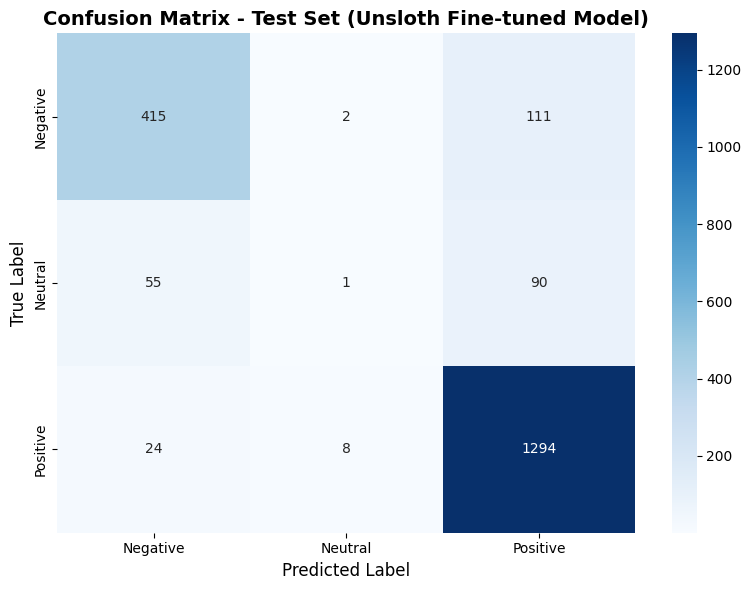

In [18]:
# Final evaluation on test set
print("=" * 60)
print("FINAL EVALUATION ON TEST SET")
print("=" * 60)
print("⚠️  This is the FIRST and ONLY time the test set is used")
print("⚠️  Model selected based on validation performance only\n")

# For full evaluation, use entire test set (may take time)
# For faster evaluation, use a sample
FULL_TEST_EVAL = False  # Set to True for full test set evaluation

if FULL_TEST_EVAL:
    test_texts = df_test['text'].values
    y_test_true = y_test
    print(f"Evaluating on full test set ({len(test_texts):,} samples)...")
else:
    # Sample for faster evaluation
    test_sample_size = min(2000, len(df_test))
    test_sample_idx = np.random.choice(len(df_test), test_sample_size, replace=False)
    test_texts = df_test.iloc[test_sample_idx]['text'].values
    y_test_true = y_test[test_sample_idx]
    print(f"Evaluating on test set sample ({len(test_texts):,} samples)...")
    print("(Set FULL_TEST_EVAL=True for full evaluation)")

# Predict
print("Running predictions...")
y_test_pred = []
for i, text in enumerate(test_texts):
    if (i + 1) % 100 == 0:
        print(f"  Processed {i+1}/{len(test_texts)} samples...")
    pred = predict_sentiment(text)
    y_test_pred.append(pred)

# Convert to numeric labels
y_test_pred_numeric = np.array([string_to_label(pred) for pred in y_test_pred])
y_test_true_numeric = np.array([string_to_label(label_to_string(label)) for label in y_test_true])

# Metrics
test_acc = accuracy_score(y_test_true_numeric, y_test_pred_numeric)
print(f"\n✓ Test Evaluation Complete")
print(f"  Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"\nClassification Report:")
print(classification_report(y_test_true_numeric, y_test_pred_numeric,
                          target_names=['Negative', 'Neutral', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(y_test_true_numeric, y_test_pred_numeric)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix - Test Set (Unsloth Fine-tuned Model)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("=" * 60)


## 15. Example Predictions

Show some example predictions vs true labels.


In [19]:
# Show example predictions
print("Example Predictions:")
print("=" * 60)

n_examples = 10
for i in range(min(n_examples, len(test_texts))):
    true_label = label_to_string(y_test_true_numeric[i])
    pred_label = y_test_pred[i]
    match = "✓" if true_label == pred_label else "✗"

    print(f"\nExample {i+1} [{match}]")
    print(f"  Text: {test_texts[i][:150]}...")
    print(f"  True Label: {true_label}")
    print(f"  Predicted:  {pred_label}")

print("\n" + "=" * 60)


Example Predictions:

Example 1 [✓]
  Text: Lolve tricolor and shine. Will buy more!!!...
  True Label: Positive
  Predicted:  Positive

Example 2 [✓]
  Text: They go on hard and break.Also don't stay on. I threw them all out....
  True Label: Negative
  Predicted:  Negative

Example 3 [✓]
  Text: Exactly what I expected. The plastic packaging was dented in but not an issue for me....
  True Label: Positive
  Predicted:  Positive

Example 4 [✓]
  Text: Great price, mostly because sorbitol is used, not xylitol which is apparently more expensive. Happily, sorbitol seems to be much less toxic to dogs th...
  True Label: Positive
  Predicted:  Positive

Example 5 [✓]
  Text: Works well...
  True Label: Positive
  Predicted:  Positive

Example 6 [✓]
  Text: lasts for months ! & it still can be wore again...
  True Label: Positive
  Predicted:  Positive

Example 7 [✓]
  Text: It’s perfect. It blend naturally. I love it. I have brown to light complexion...
  True Label: Positive
  Predicted: 

## 16. Summary

### Key Results:
- **Model**: Llama-3.1-8B fine-tuned with Unsloth (LoRA + 4-bit)
- **Training**: Instruction-following format with chronological split
- **Test Accuracy**: See results above

### Reproducibility:
- ✅ Random seeds set (RANDOM_STATE=319302)
- ✅ Chronological split (no shuffling)
- ✅ Same label mapping as Week 4 (0=Negative, 1=Neutral, 2=Positive)

### Data Leakage Prevention:
- ✅ Chronological split by timestamp
- ✅ No shuffling before split
- ✅ Test set used only once

### Next Steps:
- Increase epochs (2-3) for better performance
- Tune LoRA rank (r) and learning rate
- Try different base models (Qwen2.5, Mistral)
- Full test set evaluation (set FULL_TEST_EVAL=True)
